# LinkNet: нейронная сеть для семантической сегментации изображений

Abhishek Chaurasia, Eugenio Culurciello, Jun 2017, https://arxiv.org/abs/1707.03718

Воспользуемся LinkNet для сегментации изображений $128 \times 128$, в которых в случайном месте располагается изображение MNIST $28 \times 28$ и добавлен шум из фрагментов других картинок из базы. 

Каждый фрагмент выбирается из случайного изображения и поворачивается на угол, выбранный из равномерного на $[0,360]$ распределения. Координаты левого верхнего угла фрагмента выбираются из равномерного $U(0, 128-s)$ или нормального $N\left(\frac{128-s}{2}, \left(\frac{128-s}{4}\right)^2\right)$ распределения, где $s$ - ширина (высота) повёрнутого фрагмента.

In [1]:
import sys
import os
import numpy as np
import tensorflow as tf
from time import time

import matplotlib.pyplot as plt

sys.path.append('..')

from dataset import Dataset, DatasetIndex
from linknet import LinkNetBatch
from plot_functions import plot_example_interactive, plot_examples

%matplotlib inline

In [2]:
MNIST_SIZE = 65000
BATCH_SIZE = 512
MAX_ITER = 300

In [3]:
# создадим индекс и датасет для построения пайплайна

ind = DatasetIndex(np.arange(MNIST_SIZE))
mnistset = Dataset(ind, batch_class=LinkNetBatch)
mnistset.cv_split([0.9, 0.1])

In [4]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

In [5]:
prediction = []
test_loss = []
train_loss = []

In [6]:
# пайплайны для обучения и контроля

level = 1           # интенсивность шума ([0, 1])
n_fragments = 100   # количество шумовых фрагментов   
size = 12           # размер шумового фрагмента (1, ..., 27)
distr = 'normal'    # распределение шумовых фрагментов на изображении ('normal' или 'uniform')

ppl = mnistset.train.pipeline()\
        .load_images()\
        .random_location() \
        .create_mask()\
        .add_noise('mnist_noise', level, n_fragments, size, distr)\
        .train(sess)\
        .get_stat(sess, train_loss, True)\
        
ppl_test = mnistset.test.pipeline()\
            .load_images()\
            .random_location() \
            .create_mask()\
            .add_noise('mnist_noise', level, n_fragments, size, distr)

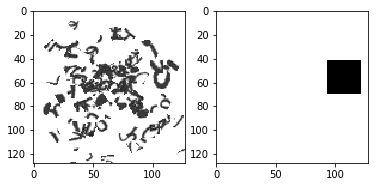

In [7]:
images = []
masks = []
ppl_test.get_images(images, masks).next_batch(100, n_epochs=None)
plt.subplot(121)
plt.imshow(images[0][0], cmap='gray_r')
plt.subplot(122)
plt.imshow(masks[0][0], cmap='gray_r')
plt.show()

In [ ]:
# обучение

start = time()
for i in range(MAX_ITER):
    ppl.next_batch(BATCH_SIZE, n_epochs=None)
    ppl_test.get_stat(sess, test_loss, False).next_batch(100, n_epochs=None)
    if (i+1) % 20 == 0:
        print("Iter {:3d}: train {:05.3f} test {:05.3f}".format(i+1, 
                                                                train_loss[-1], 
                                                                test_loss[-1]))
stop = time()
print("Train time: {:05.3f} min".format((stop-start)/60))

Iter  20: train 0.409 test 0.406
Iter  40: train 0.280 test 0.280
Iter  60: train 0.206 test 0.204
Iter  80: train 0.160 test 0.157
Iter 100: train 0.134 test 0.142
Iter 120: train 0.122 test 0.125
Iter 140: train 0.108 test 0.101
Iter 160: train 0.098 test 0.098
Iter 180: train 0.091 test 0.082
Iter 200: train 0.087 test 0.099
Iter 220: train 0.090 test 0.096
Iter 240: train 0.078 test 0.078
Iter 260: train 0.082 test 0.087
Iter 280: train 0.076 test 0.087
Iter 300: train 0.076 test 0.085
Train time: 112.244 min


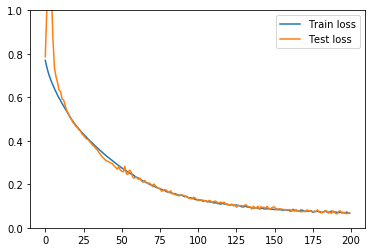

In [14]:
plt1, = plt.plot(train_loss,  label='Train loss')
plt2, = plt.plot(test_loss, label='Test loss')
plt.legend(handles=[plt1, plt2])
plt.ylim((0, 1))
plt.show()

In [15]:
prediction = []
images = []
masks = []
ppl_test.get_images(images, masks)\
        .predict_proba(sess, prediction).next_batch(10, n_epochs=None)

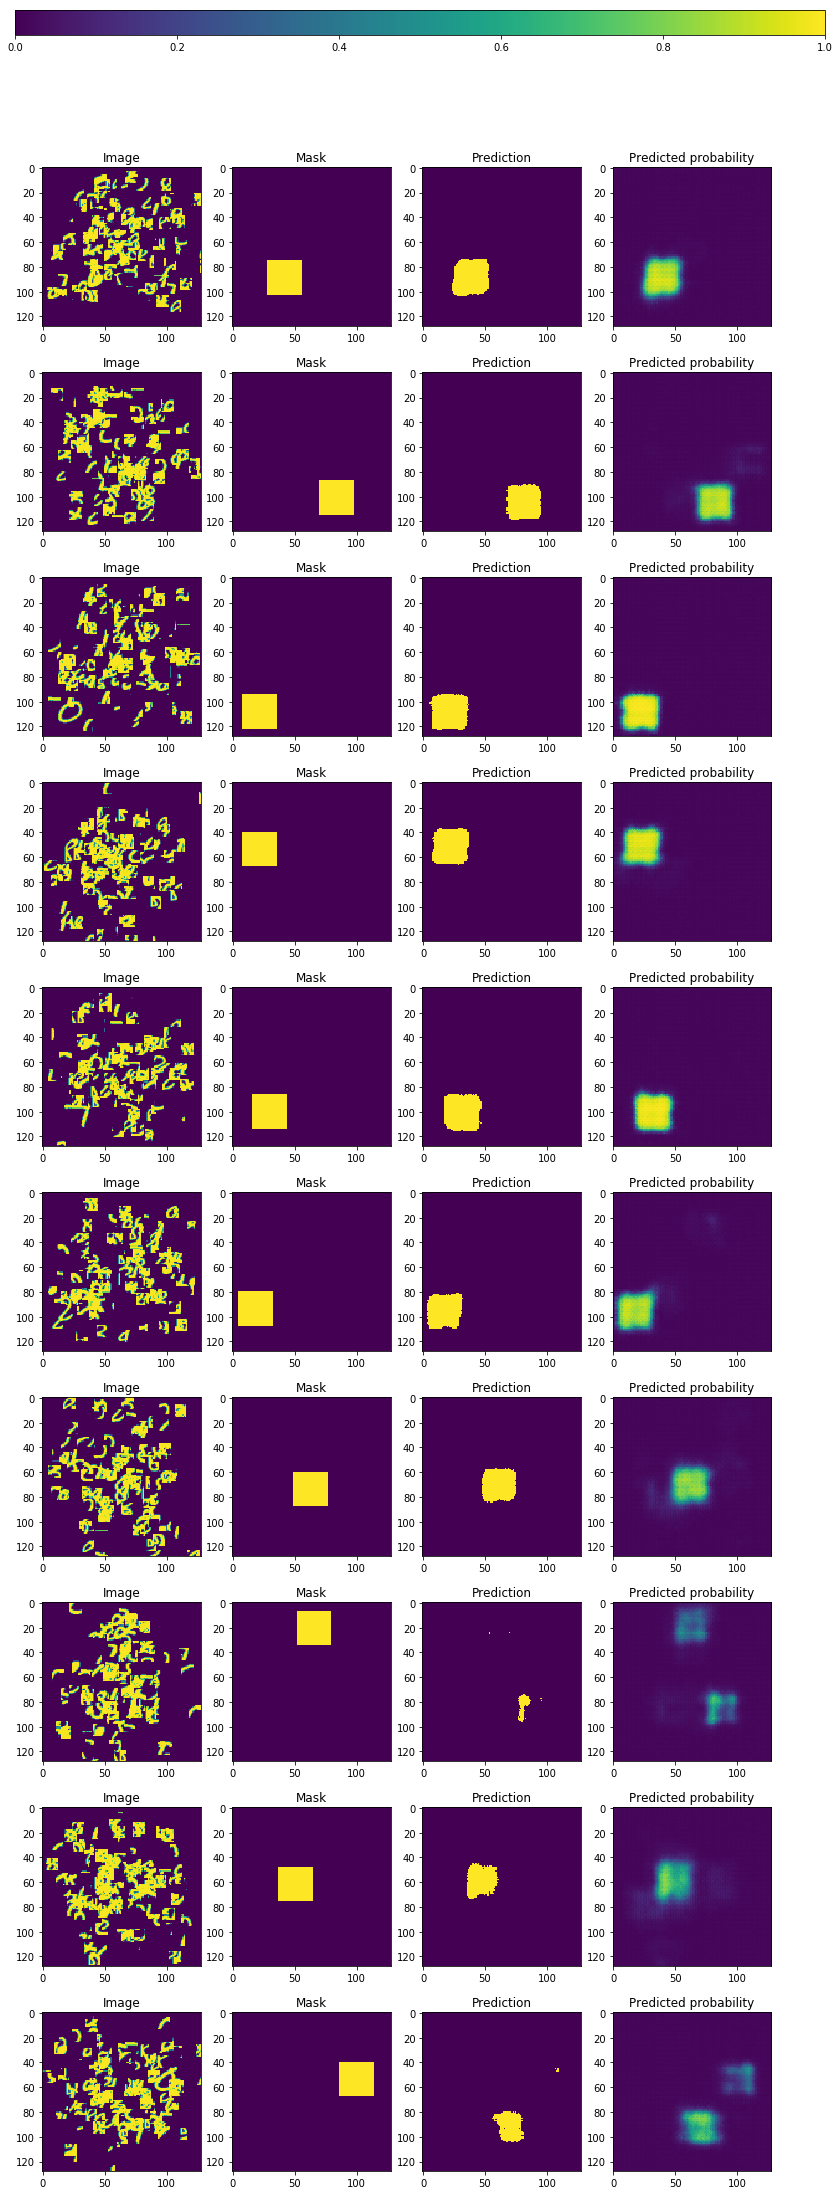

In [16]:
plot_examples(images, masks, prediction)